In [1]:
import numpy as np
import scipy.optimize as Optim
import matplotlib.pyplot as plt
from iminuit import Minuit as Min


---
PART I

In [2]:
data = np.loadtxt('datafile-exp.txt')

In [3]:
data

array([4.30037023, 7.01717053, 1.50516787, ..., 7.95496438, 0.44902867,
       0.67637281])

In [4]:
data.shape

(10000,)

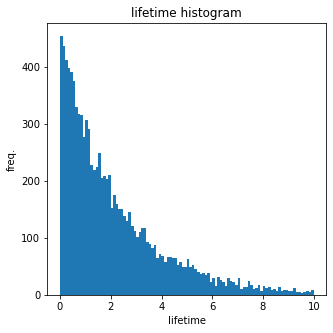

In [5]:
plt.figure(figsize = (5,5))
freq, lifetime, _ = plt.hist(data, bins = int(np.sqrt(data.shape[0])))
plt.xlabel('lifetime')
plt.ylabel('freq.')
plt.title('lifetime histogram')
plt.show()

In [6]:
min_tau = 0.
max_tau = 10.

In [7]:
def pdf(t, tau):
    if tau == 0:
        return 0.
    norm = tau*(np.exp(-min_tau/tau)-np.exp(-max_tau/tau))
    return np.exp(-t/tau)/norm

def L(t, tau):
    return np.prod(pdf(t,tau))

def NLL(t,tau):
    return -np.sum(np.log(pdf(t,tau)))

def NLLfit(tau):
    return NLL(data,tau)



[2.20434542]


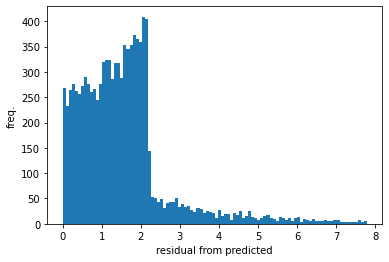

In [8]:
#scipy attempt, errors difficult
res = Optim.minimize(NLLfit, x0 = [2.], )

print(res.x)

errs = np.abs(data - res.x)

plt.hist(errs, bins = int(np.sqrt(len(errs))))
plt.xlabel('residual from predicted')
plt.ylabel('freq.')
plt.plot()

minNLL = NLL(data, res.x)

In [9]:
#Minuit solution, with error
pNames = ['tau']
start = {
    pNames[0]: 2.,
}
theMin = Min(NLLfit,**start)
theMin.errors = [0.1]
theMin.errordef = 0.5
theMin.limits = [(0,None)]
result = theMin.migrad()
result

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.731e+04                  │              Nfcn = 21               │
│ EDM = 6.59e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau  │   2.204   │   0.025   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────┐
│     │      tau │
├─────┼──────────┤
│ tau │ 0.000627 │
└─────┴──────────┘

In [10]:
result.values

<ValueView tau=2.204336281167105>

In [11]:
result.errors

<ErrorView tau=0.025042997158954527>

---

PART 2

In [12]:
data2 = np.loadtxt('datafile-expresonance.txt')

In [13]:
data2

array([3.65247717, 5.51613443, 1.34167698, ..., 4.38368558, 2.47191837,
       4.86731043])

In [14]:
nevents = len(data2)
nevents

10000

[]

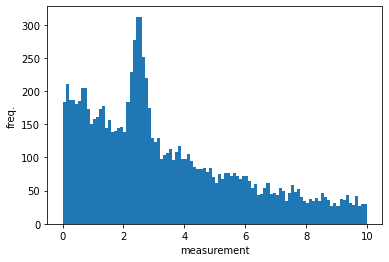

In [15]:
plt.hist(data2,bins = int(np.sqrt(nevents)))
plt.xlabel('measurement')
plt.ylabel('freq.')
plt.plot()

In [16]:
#Setting fixed parameters
width = 0.2
exp_mean = 2.5
exp_life = 5.
min_life = 0.
max_life = 10.
frac_expo = 0.9
frac_gauss = 0.1

In [17]:
def gauss(x,mean,sigma):
    #Gaussian part
    res = np.exp(-0.5*(x-mean)**2/sigma**2)/(sigma*np.sqrt(2*np.pi))
    return res #/np.sum(res)

def exponential(x, tau):
    #Exponential part
    res = np.exp(-x/tau)
    #Normalisation over interval min_life to max_life
    norm = tau*(np.exp(-min_life/tau)-np.exp(-max_life/tau))
    return res/norm #/np.sum(res)
    
def pdf(x, tau, mean, F):
    #Total = Weighted sum of parts
    P = (1-F)*gauss(x, mean, width) + F*exponential(x,tau)
    P[P<=0] = 1e-8
    return P

def NLL2(x,tau, mean, F):
    #negative log likelihood
    return -np.sum(np.log(pdf(x, tau,mean,F)))

def NLL2fit(tau,mean,F):
    #function to fit for minuit
    #print(tau,' ',mean, ' ', F)
    return NLL2(data2,tau,mean,F)

def NLL2fit_scipy(args):
    #function to fit scipy
    tau = args[0]
    mean = args[1]
    F = args[2]
    return NLL2(data2,tau,mean,F)


In [18]:
#scipy, no errors
res2 = Optim.minimize(NLL2fit_scipy, x0 = [4.,2.,0.5], method = 'L-BFGS-B',tol = 1e-6)
res2

      fun: 21015.307517707777
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.32232492, -3.7292921 , -0.05711627])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 12
     njev: 19
   status: 0
  success: True
        x: array([5.03994143, 2.49934998, 0.90287439])

In [19]:
#Minuit, with errors
pNames = ['tau', 'mean','F']
start = {
    pNames[0]:2,
    pNames[1]:2.,
    pNames[2]:0.5
}
theMin2 = Min(NLL2fit,**start)
theMin2.errors = [0.1,0.1,0.01]
theMin2.errordef = 0.5
theMin2.limits = [(0,None),None, (0,1)]
result2 = theMin2.migrad()
result2

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.102e+04                  │              Nfcn = 110              │
│ EDM = 3.07e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau  │   5.04    │   0.10    │            │            │    0    │         │       │
│ 1 │ mean │   2.500   │   0.012   │            │            │         │         │       │
│ 2 │ F    │   0.903   │   0.005   │            │            │    0    │    1    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────┐
│      │       tau      mean         F │
├──────┼───────────────────────────────┤
│  tau │    0.0106 -4.18e-05 -4.48e-05 │
│ mean │ -4.18e-05  0.000139  8.39e-07 │
│    F │ -4.48e-05  8.39e-07  2.03e-05 │
└──────┴───────────────────────────────┘